In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the file 
video = pd.read_csv('video.csv')

# look at a sample
video.sample(10)

,video_id,category_id,category_title,publishedAt,trending_date,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,trending_days,view_increase,like_increase,comment_increase,diff_days,engagement,new_case,new_death
1545,HkTTPu_p2ps,10,Music,2020-08-08,2020-08-12,530924,33215,1116,1921,False,False,1 days,48409,964,34,4 days,615467,55894,1513
3895,OfGIhCpXip4,17,Sports,2020-09-27,2020-09-29,1175137,16963,904,877,False,False,1 days,141235,1067,69,2 days,1335348,36963,732
3965,3UFZfaWQdtA,17,Sports,2020-10-12,2020-10-13,975759,16907,1497,4294,False,False,5 days,297822,2833,757,1 days,1298372,48417,724
2680,TcKTSev1_Do,26,Howto & Style,2020-11-28,2020-11-29,864610,65278,1055,7274,False,False,2 days,330444,16518,1384,1 days,1285508,136090,823
3477,hHTGdglw4UI,25,News & Politics,2020-09-05,2020-09-07,174801,1615,531,2144,False,False,5 days,76565,617,639,2 days,256381,28142,227
3850,ErzqKnB6opA,17,Sports,2020-09-24,2020-09-25,1344357,17600,439,1231,False,False,3 days,257261,1518,67,1 days,1622034,55186,849
2961,DWQ-pI_iNZU,23,Comedy,2020-10-26,2020-10-26,94368,5870,96,1245,False,False,5 days,105632,2550,372,0 days,210037,62535,399
1075,QpkOyicefO0,24,Entertainment,2020-09-26,2020-09-27,1032656,85046,611,2811,False,False,5 days,724808,28988,828,1 days,1875137,34983,307
880,EqhrnS3qBcI,24,Entertainment,2020-08-25,2020-08-27,340073,4327,250,604,False,False,3 days,125431,937,101,2 days,471473,43915,1128
4270,WXRFYiMlMLs,2,Autos & Vehicles,2020-09-22,2020-09-23,901247,36732,852,7405,False,False,5 days,833303,14233,2437,1 days,1795357,38619,1159


### Convert Data types

In [3]:
# look at the data types 
video.dtypes

video_id             object
category_id           int64
category_title       object
publishedAt          object
trending_date        object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
comments_disabled      bool
ratings_disabled       bool
trending_days        object
view_increase         int64
like_increase         int64
comment_increase      int64
diff_days            object
engagement            int64
new_case              int64
new_death             int64
dtype: object

In [4]:
# convert categorical variables to categories 
for col in ['category_title','comments_disabled','ratings_disabled']:
    video[col] = video[col].astype('category')
    
# convert the diff_days to int64
for i in range(len(video['diff_days'])):
    video['diff_days'][i] = video['diff_days'][i].split()[0]

video['diff_days'] = video['diff_days'].astype('int')

# convert the trending days to int64
for i in range(len(video['trending_days'])):
    video['trending_days'][i] = video['trending_days'][i].split()[0]

video['trending_days'] = video['trending_days'].astype('int')

In [5]:
# look at the data types again
video.dtypes

video_id               object
category_id             int64
category_title       category
publishedAt            object
trending_date          object
view_count              int64
likes                   int64
dislikes                int64
comment_count           int64
comments_disabled    category
ratings_disabled     category
trending_days           int64
view_increase           int64
like_increase           int64
comment_increase        int64
diff_days               int64
engagement              int64
new_case                int64
new_death               int64
dtype: object

In [6]:
# look at the statistical summary 
video.describe(include = ['int64']).T.round(3)

,count,mean,std,min,25%,50%,75%,max
category_id,4320.0,18.406,7.144,1.0,10.00,20.0,24.00,29.0
view_count,4320.0,1324839.650,2808937.012,0.0,298813.25,600527.0,1296550.00,76805026.0
likes,4320.0,105409.476,292797.998,0.0,13692.75,32950.5,86434.75,7045907.0
dislikes,4320.0,1954.720,9944.988,0.0,236.00,539.0,1441.00,405329.0
comment_count,4320.0,11665.528,72404.655,0.0,1404.75,3127.0,7550.50,2314087.0
trending_days,4320.0,4.370,1.882,0.0,3.00,4.0,5.00,30.0
view_increase,4320.0,1601232.016,5628449.860,0.0,151701.00,438358.5,1151287.00,175419930.0
like_increase,4320.0,50693.153,230824.327,0.0,3041.25,12118.0,37487.25,8689626.0
comment_increase,4320.0,5707.743,71902.612,0.0,268.75,824.0,2395.50,3751143.0
diff_days,4320.0,1.352,1.291,0.0,1.00,1.0,2.00,27.0


In [7]:
# look at the categorical variables 
video.describe(include = "category").T

,count,unique,top,freq
category_title,4320,15,Music,970
comments_disabled,4320,2,False,4247
ratings_disabled,4320,2,False,4281


- the top1 category is Music 

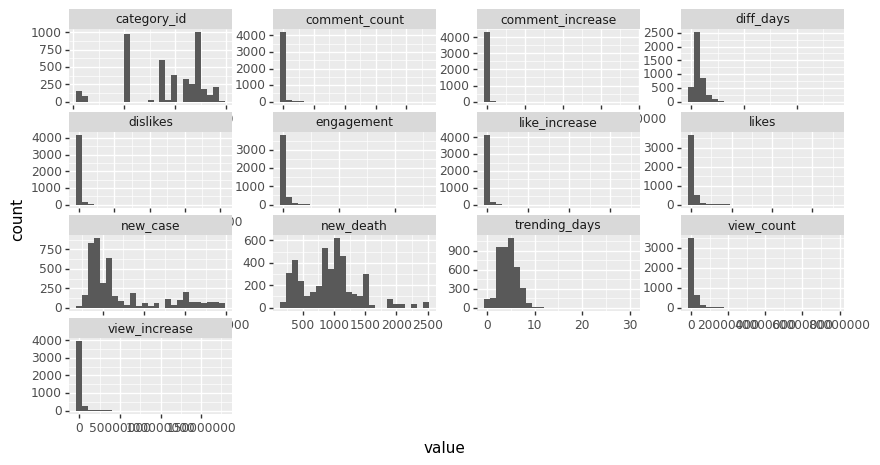

<ggplot: (8771362749639)>

In [8]:
# Plot the continuous Variables 
continuous = video.select_dtypes(include="int64").melt()
(
    ggplot(continuous,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

- The variables have skewed distributions, so I will try log transformation. 
- I will not log engagement, the outcome variable, because I will recode it as a binary variable

In [9]:
# log transformation 
for col in ['comment_count','comment_increase','dislikes','like_increase','likes','view_count','view_increase']:
    for i in range(len(video[col])):
        # for non-zero value only 
        if video[col][i] != 0:
            video[col][i] = np.log(video[col][i])

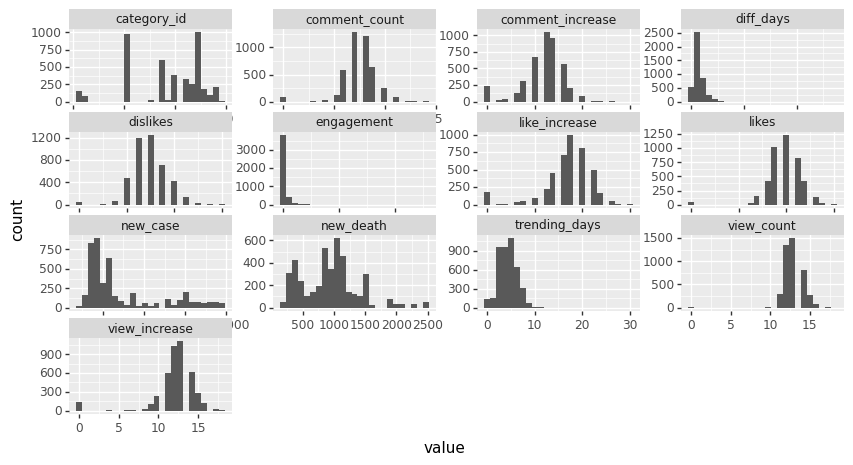

<ggplot: (8771368905912)>

In [10]:
# Plot the continuous Variables again
continuous = video.select_dtypes(include="int64").melt()
(
    ggplot(continuous,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

- The distributions are more like normal distributions now. 

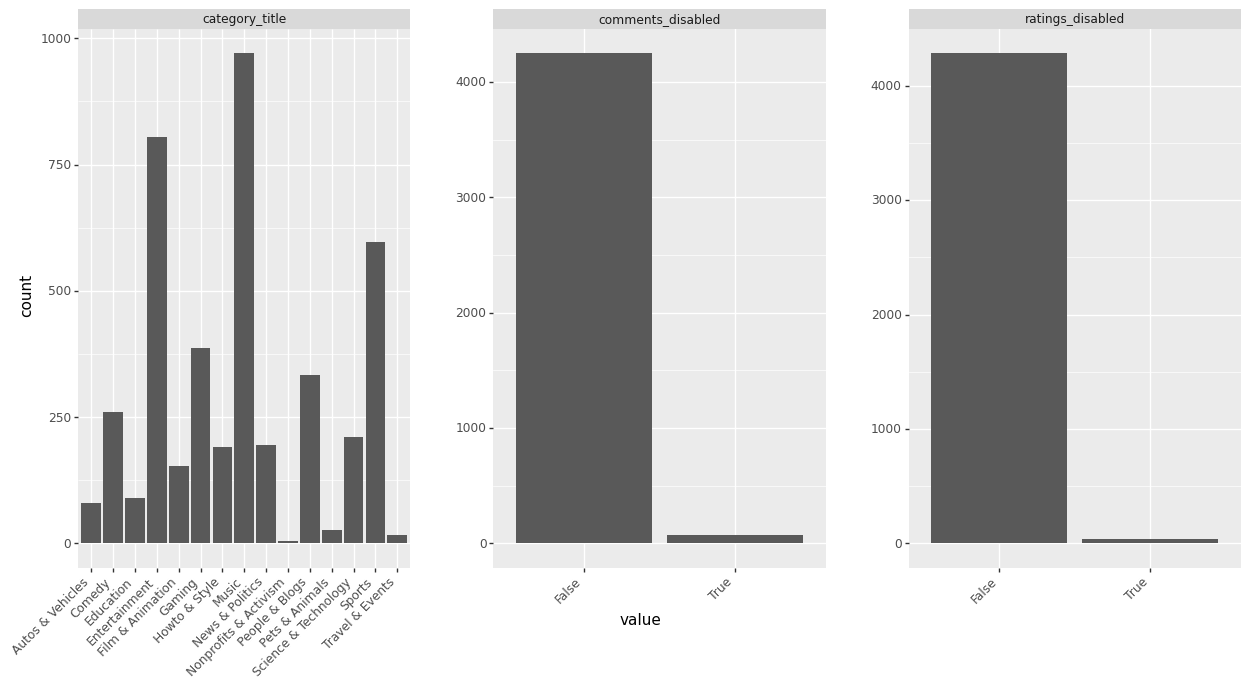

<ggplot: (8771368917330)>

In [11]:
# plot for categorical variables 
category = video.select_dtypes(include = 'category').melt()
(
    ggplot(category,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)


### Recoding

In [12]:
# create the dummy variable for comment_disabled videos
video['comments_disabled'] = 1*(video['comments_disabled'] == "True")

In [13]:
# create a dummy for rating_disabled videos 
video['ratings_disabled'] = 1*(video['ratings_disabled'] == "True")

In [14]:
# create a dummy for each category in the category title variable
category_dummies = pd.get_dummies(video.category_title)

In [15]:
# set the Nonprofits & Activism as reference group 
category_dummies = category_dummies.drop(['Nonprofits & Activism'], axis = 1) 

In [16]:
# concatenate 
video = pd.concat([video.drop(['category_id','category_title'],axis=1),category_dummies],axis=1)

### Recode the outcome variable 

- Research Question: if a person makes a new video weekly (which is the most common case for a professional YouTuber), what is the probability that the person can earn more than the average weekly salary in the U.S.

- The average weekly salary in the U.S. is $994

- Based on previoud studies, 1000 viewer engagement can bring 3 dollars to 10 dollars profits. 
- I will take the mean of the profits, which is 6.5.
- So, to provide 994 profits, a video needs to have 152923 viewer engagement

In [17]:
video['engagement'] = 1*(video['engagement'] > 152923)

### Split the data 

In [18]:
# set seeds 
np.random.seed(202011)

# train-test split 
train = video.sample(frac = .75).reset_index(drop = True)
test = video.drop(train.index).reset_index(drop = True)

# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# check the proportions
print(train.shape[0]/video.shape[0])
print(test.shape[0]/video.shape[0])

Training Data: 3240 
Test Data: 1080
0.75
0.25


### Build a machine learning pipeline

In [19]:
# (0) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

# (1) preprocessing and initialize pipe 
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

# (2) Specify the models and their repsective tuning parameters. 
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500],
    'model__max_features':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]}
    
]

# (3) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)


### Run the models 

In [20]:
train.columns

Index(['video_id', 'publishedAt', 'trending_date', 'view_count', 'likes',
       'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled',
       'trending_days', 'view_increase', 'like_increase', 'comment_increase',
       'diff_days', 'engagement', 'new_case', 'new_death', 'Autos & Vehicles',
       'Comedy', 'Education', 'Entertainment', 'Film & Animation', 'Gaming',
       'Howto & Style', 'Music', 'News & Politics', 'People & Blogs',
       'Pets & Animals', 'Science & Technology', 'Sports', 'Travel & Events'],
      dtype='object')

In [21]:
# set the variables
train_y = train['engagement']
train_x = train[['comments_disabled','ratings_disabled','trending_days','diff_days',
                'new_case','new_death','Autos & Vehicles','Comedy','Education','Entertainment','Film & Animation',
                'Gaming','Howto & Style','Music','News & Politics','People & Blogs','Pets & Animals',
                'Science & Technology','Sports','Travel & Events']]

In [22]:
# run
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=2,
                                                           max_features=18,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 3, 4],
                          'model__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                  11, 12, 13, 14, 15, 16, 17,
                                 

### Identify which model performed the best using the area under the ROC curve (AUC) metric

In [23]:
search.best_score_

0.7805304075520388

### search.best_params_

In [24]:
search.best_estimator_

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=2, max_features=18,
                                        n_estimators=1500))])

In [25]:
# save the best parameters 
rf_mod = search.best_estimator_

In [26]:
# the performance on the in-sample data 
m.roc_auc_score(train_y,rf_mod.predict_proba(train_x)[:,1])

0.8588381835804515

In [27]:
test_y = test['engagement']
test_x = test[['comments_disabled','ratings_disabled','trending_days','diff_days',
                'new_case','new_death','Autos & Vehicles','Comedy','Education','Entertainment','Film & Animation',
                'Gaming','Howto & Style','Music','News & Politics','People & Blogs','Pets & Animals',
                'Science & Technology','Sports','Travel & Events']]

In [28]:
# look at the performance on the test data 
m.roc_auc_score(test_y,rf_mod.predict_proba(test_x)[:,1])

0.7595283018867923

In [29]:
m.accuracy_score(train_y,rf_mod.predict(train_x))

0.9882716049382716

### Examine the variable importance

In [30]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [31]:
# Permute the features to determine importance
vi = permutation_importance(rf_mod,train_x,train_y,n_repeats=30)

In [32]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,diff_days,0.000309,0.000000,0.000309,0.000309
1,Science & Technology,0.000278,0.000093,0.000093,0.000463
2,trending_days,0.000267,0.000105,0.000058,0.000477
3,comments_disabled,0.000000,0.000000,0.000000,0.000000
4,Gaming,0.000000,0.000000,0.000000,0.000000
5,Sports,0.000000,0.000000,0.000000,0.000000
6,Pets & Animals,0.000000,0.000000,0.000000,0.000000
7,People & Blogs,0.000000,0.000000,0.000000,0.000000
8,News & Politics,0.000000,0.000000,0.000000,0.000000
9,Music,0.000000,0.000000,0.000000,0.000000


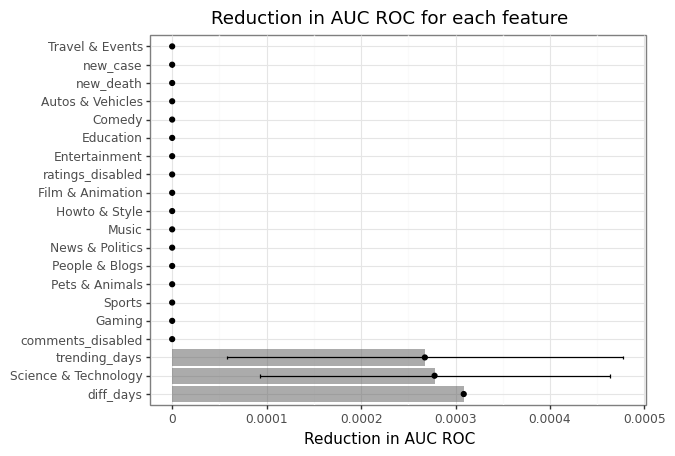

<ggplot: (8771368222251)>

In [33]:
# to visualize 
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="", title = ('Reduction in AUC ROC for each feature'))
)

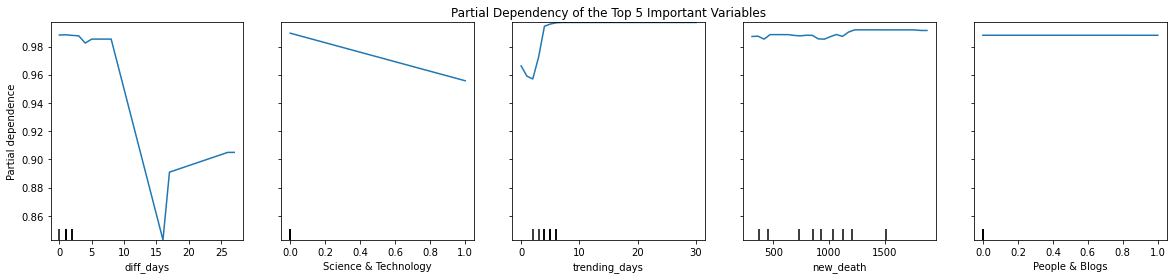

In [43]:
# Target specific features
features = ['diff_days','Science & Technology','trending_days','new_death','People & Blogs']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(20, 4))
fig, ax.set_title('Partial Dependency of the Top 5 Important Variables')
display = plot_partial_dependence(
    rf_mod, train_x, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

### Re-run the model 

In [35]:
# (0) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

# (1) preprocessing and initialize pipe 
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

# (2) Specify the models and their repsective tuning parameters. 
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500],
    'model__max_features':[1,2,3,4,5]}
    
]

# (3) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)


In [36]:
# set the variables
train_y = train['engagement']
train_x = train[['trending_days','diff_days','new_death','People & Blogs',
                'Science & Technology']]

In [37]:
# run
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=4,
                                                           max_features=3,
                                                           n_estimators=500)],
                          'model__max_depth': [2, 3, 4],
                          'model__max_features': [1, 2, 3, 4, 5],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [38]:
search.best_score_

0.7823119749998781

In [39]:
search.best_estimator_

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=4, max_features=3,
                                        n_estimators=500))])

In [40]:
# save the best parameters 
rf_mod = search.best_estimator_

In [41]:
# the performance on the in-sample data 
m.roc_auc_score(train_y,rf_mod.predict_proba(train_x)[:,1])

0.933990980382733

In [42]:
m.accuracy_score(train_y,rf_mod.predict(train_x))

0.9882716049382716